<a href="https://colab.research.google.com/github/DamiAladesuru/MachineLearning2023/blob/main/6800_Day4-5_Damilola_Aladesuru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4-5: Code used during lecture and lab assignment


## Instructions

- The notebook combines 'code used during lecture' with the corresponding lab assignment (see further down)
- Please add answers/discussion/comments to the notebook as comments or text box. Do not create another file in addition.
- When you are done with your assignment, save the notebook in drive and add your last name to the name of the file.
- To hand in the final notebook follow the instructions provided by email



## Code used during lecture



In [1]:
mport numpy as np
import pandas as pd
import scipy as sc
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import linear_model

In [2]:
# Set the numpy random seed
np.random.seed(100)

First generate simulated data for known DGP

In [3]:
# code for creating simulated data
N = 10000
K = 3
sig = 0.3
mean = np.random.randint(0,40,K)
# TODO repalce with automatic option to allow for different K
cov = np.array([[30,0,0],[0,5,0],[0,0,15]])
mean

array([ 8, 24,  3])

In [4]:
# create characteristics/explantory variables
X = np.random.multivariate_normal(mean, cov,N)
X.shape

(10000, 3)

In [5]:
# Check that cov is correct
np.cov(X,rowvar=False)

array([[ 3.00680076e+01, -1.78435356e-02,  3.41815404e-01],
       [-1.78435356e-02,  4.99279043e+00, -1.42537061e-02],
       [ 3.41815404e-01, -1.42537061e-02,  1.49284204e+01]])

In [6]:
# Add a constant to X
Xc = np.concatenate([np.ones([N,1]),X],axis=1)
# Get beta values
beta = pd.DataFrame(np.random.randint(0, 20, (Xc.shape[1],1)),index=['const']+[f"beta{i}" for i in range(1,Xc.shape[1])],columns=['beta_true'])
beta


,beta_true
const,11
beta1,2
beta2,16
beta3,4


In [7]:
# create random white noise error
errStd = 50
err = np.random.normal(0, errStd, (N,1))

# Create dependent variable y=Xb+e
Y = np.matmul(Xc,beta.values)+err
Y

array([[396.46052266],
       [386.98982491],
       [476.35024423],
       ...,
       [389.56423796],
       [448.76525949],
       [390.78724315]])

Run LASSO on simulated data

Compare to the true data generating process


In [9]:
# Estimate the model with Lasso
# Check how alpha affects the estimation
res = beta.transpose().copy()
lstBetaCols = list(res.columns)

lstAlpha = np.logspace(-5, 1, num = 10, base = 2)
# Loop over a range of alpha value
for alpha in lstAlpha:
  # Estimate Lasso
  modLasso = Lasso(fit_intercept=True, alpha=alpha)
  modLasso.fit(X, Y[:,0])

  # Add estimated coef to result dataframe
  # Note, I rounded alpha in the variable name just to make it more readable
  res.loc[f'beta_hat_alpha_{round(alpha,3)}','alpha'] = alpha
  res.loc[f'beta_hat_alpha_{round(alpha,3)}','const'] = modLasso.intercept_
  res.loc[f'beta_hat_alpha_{round(alpha,3)}',lstBetaCols[1:]] = modLasso.coef_.transpose()

res

,const,beta1,beta2,beta3,alpha
beta_true,11.000000,2.000000,16.000000,4.000000,NaN
beta_hat_alpha_0.031,12.965379,2.016024,15.908095,3.960265,0.031250
beta_hat_alpha_0.05,13.062126,2.015426,15.904412,3.959045,0.049606
beta_hat_alpha_0.079,13.215702,2.014475,15.898567,3.957109,0.078745
beta_hat_alpha_0.125,13.459489,2.012966,15.889287,3.954036,0.125000
beta_hat_alpha_0.198,13.846476,2.010570,15.874557,3.949158,0.198425
beta_hat_alpha_0.315,14.460780,2.006768,15.851174,3.941414,0.314980
beta_hat_alpha_0.5,15.435927,2.000731,15.814057,3.929122,0.500000
beta_hat_alpha_0.794,16.983877,1.991149,15.755136,3.909609,0.793701
beta_hat_alpha_1.26,19.441093,1.975939,15.661605,3.878635,1.259921


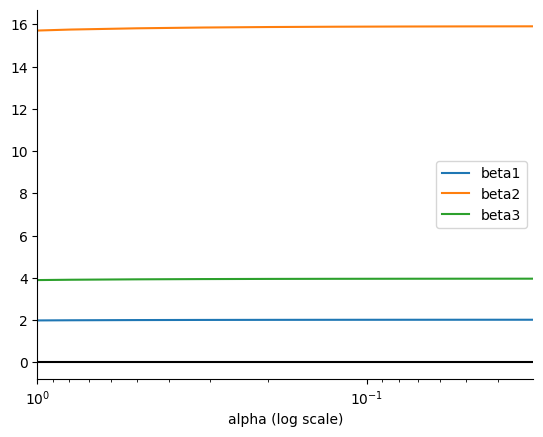

In [10]:
# Plot the estimated coeficients across different levels of alpha

import matplotlib.pyplot as plt
fig, ax = plt.subplots();
for strBeta in ['beta1','beta2','beta3']:
  ax.plot(res['alpha'],res[strBeta],label=strBeta)

ax.plot([10e5,0.031250],[0,0],color='black')
ax.set_xscale('log')
ax.set_xlabel('alpha (log scale)')
ax.invert_xaxis()
ax.set_xlim(1,0.031250)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend();

Now add a additional variable that is correlated to one of the existing variables but does not have an effect on the dependent variable

In [11]:
beta.values.squeeze()

array([11,  2, 16,  4])

In [13]:
# Lasso Simulation example
# 1) Create a variable (X4) that is linearly dependent with X3
#    The strength of the relationship is governed by the parameter "paramX4"
#    A white noise error term is added. X4 = paramX4 * X3 + err
# 2) The error term is varied in a loop
# 3) In each step X4 is created and the Lasso is estimated. Alpha in the
#    Lasso estimation is automatically determined using LassoCV (best alpha
#    selected by cross-validation).
# 4) Results are saved given:
#     - The correlation coef between X4 and X3
#     - The estimated coef from Lasso
#   => This allows to see the highest coerrelation coef for which Lasso can
#     recover the true model


from sklearn.linear_model import LassoCV

res = pd.DataFrame(columns=['corrcoef','beta1','beta2','beta3','beta4'])
res.loc['true_model',['beta1','beta2','beta3']] = beta.iloc[1:].values.squeeze()
for errStdX4 in [0,1,2,3,4,5,7.5,10,15,20,25,30,45,50,55,100,200]:
  paramX4 = 2 # This parameter specifies the strength of the relationship between
              # X3 and X4
  X4 = paramX4*X[:,[2]]+np.random.normal(0, errStdX4, (N,1))

  XPlus4 = np.concatenate([X,X4],axis=1)

  res.loc[f"errStdX4_{errStdX4}",'corrcoef'] = np.corrcoef(XPlus4[:,2],XPlus4[:,3])[0,1]
  # print(XPlus4[1,:])

  modLassoCV = LassoCV(cv=5,fit_intercept=True)
  modLassoCV.fit(XPlus4,  Y[:,0])
  coef = modLassoCV.coef_
  res.loc[f"errStdX4_{errStdX4}",'alpha'] = modLassoCV.alpha_
  res.loc[f"errStdX4_{errStdX4}",['beta1','beta2','beta3','beta4']] = coef
res

,corrcoef,beta1,beta2,beta3,beta4,alpha
true_model,NaN,2,16,4,NaN,NaN
errStdX4_0,1.0,2.013109,15.890459,0.0,1.979207,0.119216
errStdX4_1,0.991798,2.011538,15.880509,3.951129,0.0,0.168759
errStdX4_2,0.967488,2.014407,15.889604,4.22527,-0.136096,0.117595
errStdX4_3,0.933342,2.013064,15.88491,3.581532,0.18729,0.122656
errStdX4_4,0.88669,2.013771,15.895861,3.579965,0.187703,0.119663
errStdX4_5,0.842985,2.013375,15.890328,3.706037,0.123754,0.122397
errStdX4_7.5,0.716599,2.014496,15.892724,3.746036,0.103651,0.122671
errStdX4_10,0.607748,2.01277,15.891759,3.856722,0.049404,0.120869
errStdX4_15,0.459583,2.012852,15.886057,3.904788,0.02447,0.130928


# Lab 4a

The first part of today's lab will have you see if you can recover the true DGP using a LASSO

Task:

- Below you will find a DGP similar to the one above
- Try to determine the optimal alpha value in order to recover the "best" specification
- Check if this "best" specification is close to the true DGP

In [ ]:
# re-run the DGP code to get a different set of coefficients and data

In [14]:
from sklearn.datasets import make_spd_matrix

In [15]:
# Call the function to generate data

# Set the random seed such that everybody gets the same dataset
np.random.seed(11)
# Get beta values
K = 5
errStd = 3
beta = pd.DataFrame(np.random.randint(-5, 5, (K+1,1)),index=['const']+[f"beta{i}" for i in range(1,K+1)],columns=['beta_true'])
print(beta)

# Sklearn function to generate a random symmetric, positive-definite covariance matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_spd_matrix.html
Xcov = make_spd_matrix(K)
# Generate random mean for X variables
Xmean = np.random.randint(-20,20,K)

# create characteristics/explantory variables
X = np.random.multivariate_normal(Xmean, Xcov,N)

# Add a constant to X
Xc = np.concatenate([np.ones([N,1]),X],axis=1)

# create random white noise error
err = np.random.normal(0, errStd, (N,1))

# Create dependent variable y=Xb+e
Y = np.matmul(Xc,beta.values)+err


# errStdXnoiseA = 20
# errStdXnoiseB = 30

errStdXnoiseA = 2
errStdXnoiseB = 2

# XnoiseA = 2*X[:,[1]]+2*X[:,[2]]+np.random.normal(0, errStdXnoiseA, (N,1))
# XnoiseB = 2*X[:,[2]]+1*X[:,[4]]+np.random.normal(0, errStdXnoiseB, (N,1))
XnoiseA = X[:,[1]]*X[:,[3]]*np.random.normal(0, errStdXnoiseA, (N,1))+np.random.normal(0, 1, (N,1))
XnoiseB = X[:,[2]]*X[:,[4]]*np.random.normal(0, errStdXnoiseB, (N,1))+np.random.normal(0, 2, (N,1))

XNoise = np.concatenate([X,XnoiseA, XnoiseB],axis=1)


       beta_true
const          4
beta1         -5
beta2         -4
beta3          2
beta4         -4
beta5          2


In [16]:
from sklearn.model_selection import train_test_split
#  This randomly splits the data into 80% train and 20% test data
X_train, X_test, Y_train, Y_test = train_test_split(XNoise, Y, test_size = 0.2)


In [26]:
# ================================
#  Task
# ================================

# Test several alpha values and check how this effects the R2 in the test set

# Prepare dataframe to hold results (no need to change anything here)
lstBeta = [f"beta{k}" for k in range(1,K+1)]
res = pd.DataFrame(columns=lstBeta+['betaNoiseA','betaNoiseB'])
res.loc['true_model',lstBeta] = beta.iloc[1:].values.squeeze()

# This is the place to set alpha values that sould be tested
lstAlpha = np.logspace(-7, 2, num = 10, base = 2)
for alpha in  lstAlpha:

  # Specify the model you want to use
  modLasso2 = Lasso(fit_intercept=True, alpha=alpha)
  # Fit the model to data
  modLasso2.fit(X, Y[:,0])

  # Get the coeficients of the model
  coef = modLasso2.coef_

  # Save results in list (no need to change anything here)
  res.loc[f"alpha_{alpha}", lstBeta + ['betaNoiseA','betaNoiseB']] = coef
  res.loc[f"alpha_{alpha}", 'alpha'] = alpha
  res.loc[f"alpha_{alpha}", 'R2_train'] = modLasso.score(X_train, Y_train[:,0])
  res.loc[f"alpha_{alpha}", 'R2_test'] = modLasso.score(X_test, Y_test[:,0])

res


ValueError: ignored

In [27]:
# ================================
#  Optional: Alternative approach using LassoCV
# ================================
# One alternative to setting the alphas manually is to use
# CV this is implemented in LassoCV


# TODO Try to implement a LassoCV estimation


# Prepare a dataframe to hold results
# (no need to change something here, as long as you call your model "model")
print('Best Alpha: ', model.alpha_)
lstBeta = [f"beta{k}" for k in range(1,K+1)]
res = pd.DataFrame(columns=lstBeta+['betaNoiseA', 'betaNoiseB'])
res.loc['true_model',lstBeta] = beta.iloc[1:].values.squeeze()
res.loc['beta_hat',:] = model.coef_
res
# You can also check the example here:
#  https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html
# And try to prepare similar plots

NameError: ignored

# Lab 4b

The objective of the second part of today's lab is to determine the effects of protected areas on forest cover. To do this, we take the following strategy:

1) We estimate a model predicting forest cover where we use all of the observations that are not in a protected area.

2) We use this model to predict forest cover for observations with protected areas observations. This gives as a prediction about the expected forest cover given the characteristics of the cell (such as slope, elevation).

3) Using the predictions from 2) we compare the predicted forest cover with the actual forest cover. The difference between the two is the estimated effect of forest protected areas.

=> Most of the steps for the estimation should be familiar from previous labs.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# import seaborn for visualization
import seaborn as sns

In [29]:
# run this cell only once if you don't have wget installed
# its assumed you are using windows and have python installed
# only needed if you are running the notebook locally
# %pip install wget
#if not os.path.isfile('brazil_all_data_v2.gz'):
#    !python -m wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
# Download data only once and make sure it is in the same folder as the notebook

# check if brazil_all_data_v2.gz is available in the current folder and if not, download it

if not os.path.isfile('brazil_all_data_v2.gz'):
    !wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz


NameError: ignored

In [ ]:
# load data into dataframe
df = pd.read_parquet('brazil_all_data_v2.gz')

In [ ]:
# Define target (dependent) variable (% forest cover for 2018)
strY = 'perc_treecover'

# Define a list of features names (explantory variables)
lstX = [
  # 'wdpa_2017', => Exclude protected areas
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  # 'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

In [ ]:
# Split that sample in those observations that ...
#... are protected areas
df_PA = df.loc[~(df['wdpa_2017']==0),:]

#... are NOT protected areas
df_NoPA = df.loc[df['wdpa_2017']==0,:]

print('Number of observations without protected area', df_NoPA.shape[0])
print('Number of observations with protected area', df_PA.shape[0])

In [ ]:
# Select the target variable
# ... for the observations without protected areas
Y_all_NoPA = df_NoPA[strY]
# ... for the observations with protected areas
Y_PA = df_PA[strY]

# Get the features
# ... for the observations without protected areas
X_all_NoPA =  df_NoPA.loc[:,lstX]
# ... for the observations wit protected areas
X_PA_raw =  df_PA.loc[:,lstX]

Choose a ML model and features to predict deforestation

In [ ]:
# Split the data into train and test using only the the observations
# without protected areas
X_train_raw, X_test_raw, Y_train, Y_test = train_test_split(X_all_NoPA, Y_all_NoPA, test_size = 0.2)

In [ ]:

# Scale data to 0-1 range using sklearn MinMaxScalar object
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
scaler = MinMaxScaler()
# Use only the train data to fit the MinMaxScalar
scaler.fit(X_train_raw)

# Apply the MinMax transformation to the train and test data
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)


In [ ]:
# Define a function to print model stats
def printModStats(mod,X_train, Y_train,X_test, Y_test, showPlot=True):
  # Inspect the model performancefor those observations that are
  # not protected areas
  print('Score in train', mod.score(X_train, Y_train))
  print('Score in test', mod.score(X_test, Y_test))

  # Get predicted values for the test set
  Y_test_had_Tree = mod.predict(X_test)

  # Calculate MSE in test set
  mse_ols_sklearn  = mean_squared_error(Y_test,Y_test_had_Tree)
  print('\nMean squared error: ',mse_ols_sklearn)
  # The coefficient of determination: 1 is perfect prediction
  R2_ols_sklearn = r2_score(Y_test,Y_test_had_Tree)
  print('Coefficient of determination: ',R2_ols_sklearn)

  if showPlot:
    # plot Y vs Y-hat
    h = sns.jointplot(Y_test_had_Tree, Y_test, kind="hex")
    h.set_axis_labels('Y predicted', 'Y true');



In [ ]:
# Run XGBoost. In contrast to day 2 we now use XGBRegressor as our task is
# a regression task and not a classification task
import xgboost as xgb
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
model_xgb.fit(X_train, Y_train)


In [ ]:
printModStats(model_xgb,X_train, Y_train,X_test, Y_test, showPlot=True)

Now we use the trained model to make predictions for those areas with protected areas

In [ ]:
# First we need to scale the data for those observations without
# protected areas
X_PA = scaler.transform(X_PA_raw)

In [ ]:
# Lets define a function for our conterfactual that can be reused below
def calculateConterfactual(mod,X_PA):
  # Then use the train model to make predictions for protected areas
  Y_PA_had = mod.predict(X_PA)

  # Now we can compare the mean forest cover in protected area that we observer
  print(f'Predicted mean forest cover in protected Areas {np.mean(Y_PA_had):0.2f} %' )
  print(f'Actual mean forest cover in protected Areas {np.mean(Y_PA):0.2f} %', )
  print(f'Mean difference between predicted and observed forest cover: {np.mean(Y_PA-Y_PA_had):0.2f} pp')


In [ ]:
# Call function for our xgb model
calculateConterfactual(model_xgb,X_PA)

In [ ]:
# ================================
#  Task
# ================================

# Until now we have always used the default hyperparameters for XGBoost
# Lets see if we can improve model performance by optimizing some of those.
# Usually this is a rather complex and time consuming task with many
# different ways to approach this. Here we only try to optimize two paramters
# manually. Specifically we want to optimize "max_depth" (Typical values: 3-10)
# and "min_child_weight" (Typical values: 1-5).

# Hint: The caculation is quite time consuming. Coordinate in your team
#       to try as many combination as possible.

# In case you are interested you can find a complete guide for doing
# hyperparameter optimization for XGB here:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
# This is NOT required for this task here, just to give you an idea of how
# many paramter can be optimized (Note, this referes to an older sklearn version,
# therefore some of the code might need to be adjusted)

# Specify model with "max_depth" and "min_child_weight" set explicitly
model_xgb_opt = ...

# Fit model to train data
model_xgb_opt....

# Print stats
printModStats(model_xgb_opt,X_train, Y_train,X_test, Y_test, showPlot=True)

# Do conterfactual
calculateConterfactual(model_xgb_opt,X_PA)

In [ ]:
# ================================
#  Optional Task
# ================================

# Try alternative ML models and check how they perform compared to XGBoost.
# If you are using sklearn you often only have to replace one line in oder to
# change your model. LightGBM for example is an alterantive to XGBoost that
# gained popularity.
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html#lightgbm.LGBMRegressor.

## Alternative approach

- Train a model with "protected areas" included
- Select only the protected areas (in the test set)
- make a prediction for those areas for forest cover
- make a prediction for those areas for forest cover where we set the explanatory variable for "protected areas" equal to zero i.e. we make a prediction for forest cover under the assumption that those areas where not protected

In [ ]:
# Define binary variable for deforestration in 2018

Y_all = df['perc_treecover']
# Define a list of features names (explantory variables)
lstX = [
   'wdpa_2017',
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  'wdpa_2017_lag_1st_order',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

# Get the explanatory Variables
X_all =  df.loc[:,lstX]

In [ ]:


# Split the data into train and test using all observations

# Use only the train data to fit the MinMaxScalar


# Apply the MinMax transformation to the train and test data


In [ ]:
# train...


In [ ]:
# Get only those observations which are protected areas


In [ ]:
# do prediction for these as if they were not protected areas


In [ ]:
# And compare with the case they are protected



In [ ]:

# Now we can compare the mean forest cover in protected area that we observer



In [ ]:
# => Discuss pro and cons of the two approaches